In [1]:
import numpy as np  
import matplotlib.pyplot as plt  
from sklearn.cluster import KMeans
import pandas as pd
from sklearn import metrics
from scipy.spatial.distance import cdist
import imageio

from lib.file.ROI_reader import ROIFileReader
from lib.file.ROI_writer import ROIFileWriter
from lib.analysis.laminar_dist import LaminarROI, ROICreator
from lib.analysis.align import ImageAlign
from lib.utilities import *
from lib.analysis.cell_roi import RandomROISample

# implementation of single-cell identification as outlined in 
# https://www.proquest.com/docview/2838882181?pq-origsite=gscholar&fromopenview=true&sourcetype=Dissertations%20&%20Theses
# and implemented in R/Python here: https://github.com/ksscheuer/ROI_Identification
# https://github.com/ksscheuer/Single_Cell_Identification/blob/main/AutomaticallyChooseROIs_part1.R


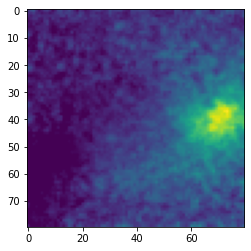

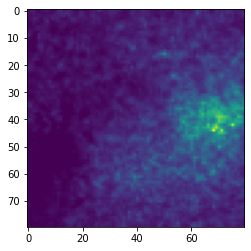

In [2]:
data_dir = "C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/scnn1a-tg3-Cre-mCherry/03-18-24/converted_zda/"
target_recording = '04_01_01'
red_rois_filename = data_dir + 'ROIs-red_' + target_recording + '.dat'
# input files: *_amp.dat, *_snr.dat   # do not normalize!
cluster_SNRcutoff = 1
k_choice = 6  # none is auto

ROI_px_cutoff = 9

data = {}
for fn in ['_amp_map.dat', '_snr_map.dat']:
    fn2 = data_dir + target_recording + fn
    data_arr = pd.read_csv(fn2,
                                 sep='\t',
                                 header=None,
                                 names=['Index',  'Values'])
    data_arr = np.array(data_arr['Values']).reshape((80, 80))
    plt.imshow(data_arr)
    plt.show()
    data[fn] = data_arr




[[3140, 3141, 3220], [1916, 1915], [1834], [2388, 2468], [2788, 2868], [3186, 3185, 3187], [3345, 3344], [3182, 3181], [2637], [2712], [2874, 2954], [2313, 2312], [2065], [3350], [2767, 2766], [4029, 4030], [2923, 2843, 2842], [3255, 3254, 3334], [3258, 3259, 3178], [3419, 3499], [4300, 4380, 4381], [4605, 4525, 4606], [3728, 3808, 3727], [3975, 3974], [4209, 4208, 4128], [4212, 4131, 4132], [3880, 3881, 3800], [3796, 3795, 3876], [1888, 1808, 1889], [3240, 3239, 3320], [3161, 3162, 3242], [3483, 3484, 3564, 4432, 4431, 4511], [4978, 4977, 4897, 4827, 4907, 4987, 4906], [3235, 3234, 3154], [3312, 3313, 3393], [5407, 5406, 5487], [5168, 5088, 5089], [2606, 2607, 2687], [3085, 3005, 3006], [3014, 3013, 2933], [2937, 2936, 2856], [2774, 2773, 2693], [2942, 2941, 2861], [3943], [3492, 3493], [3814, 3815], [2211, 2212, 2291], [2454]] 48
[[[20, 39], [21, 39], [20, 40]], [[76, 23], [75, 23]], [[74, 22]], [[68, 29], [68, 30]], [[68, 34], [68, 35]], [[66, 39], [65, 39], [67, 39]], [[65, 41], [6

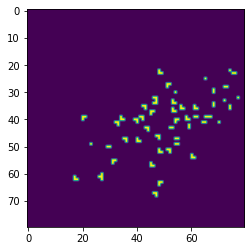

124.0


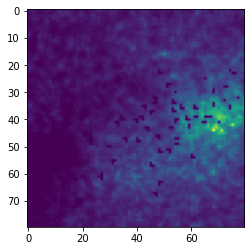

In [13]:
# open the ROI file and read the data
rfr = ROIFileReader(red_rois_filename)
red_rois = rfr.get_roi_list()

print(red_rois, len(red_rois))
red_rois = [LaminarROI(rr).get_points() for rr in red_rois]
print(red_rois, len(red_rois))
n, m = data['_amp_map.dat'].shape
red_roi_map = np.zeros((n, m))
for roi in red_rois:
    for px in roi:
        i, j = px
        red_roi_map[j][i] = 1
plt.imshow(red_roi_map)
plt.show()
print(np.sum(red_roi_map))

plt.imshow(data['_snr_map.dat'] * (1-red_roi_map))

In [7]:
# now sample pixels that are above the SNR and amplitude cutoffs but are NOT in the red ROIs
# and write them to a new ROI file
SNR_cutoff = 5
Amp_cutoff = 1.2

roi_sampler = RandomROISample(1)

# return list of lists of pairs (px)
# roi_list = roi_sampler.take_random_sample()

new_rois = []
nr_map = {}
while(len(new_rois) < 100):
    i, j = roi_sampler.get_random_point()
    if (j,i) not in nr_map \
        and data['_snr_map.dat'][i][j] > SNR_cutoff \
        and data['_amp_map.dat'][i][j] > Amp_cutoff \
        and red_roi_map[j][i] == 0:
        new_rois.append([j, i])
        nr_map[(j, i)] = 1
    if len(new_rois) > 99:
        break
print(len(new_rois))

# convert pixels to diode numbers
roi_cr = ROICreator(None)
new_rois = [[roi_cr.convert_point_to_diode_number(px)] for px in new_rois]
print(new_rois)

rfw = ROIFileWriter()
rfw.write_regions_to_dat(data_dir + 'ROIs-not-red_' 
                         + target_recording + '.dat',
               new_rois)


100
[[3103], [4302], [4940], [3178], [4543], [4055], [2855], [3993], [3256], [3597], [4296], [4307], [2856], [3107], [2777], [2624], [4707], [2785], [3104], [3496], [4217], [2791], [4237], [3429], [2957], [4288], [3679], [3588], [4949], [3032], [2068], [3099], [2229], [4626], [2479], [4142], [2874], [5508], [2698], [1584], [2477], [4290], [3901], [4773], [2055], [4135], [3910], [2867], [4455], [959], [4227], [2151], [4778], [4300], [3743], [5184], [1915], [3270], [3501], [4079], [1907], [2382], [3815], [5076], [1508], [3824], [4473], [4458], [3415], [2932], [3663], [2631], [2308], [1329], [3515], [2065], [2632], [3356], [2792], [3176], [2054], [3349], [2381], [4398], [1994], [1595], [2953], [3260], [2559], [4782], [4236], [3908], [2877], [2476], [2069], [4552], [4684], [3507], [5115], [2875]]
Regions written to: C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/scnn1a-tg3-Cre-mCherry/03-18-24/converted_zda/ROIs-not-red_04_01_01.dat


48
100


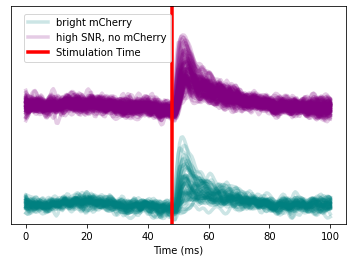

In [10]:
# plot traces for all red rois
trace_filename = data_dir + 'ROIs-red-traces_' + target_recording + '.dat'
n_traces = len(red_rois)
print(n_traces)
trace_data = pd.read_csv(trace_filename,
                         sep='\t',
                         header=0,
                         names=['Index'] + ['ROI' + str(i) for i in range(1,n_traces+1)])


plt.clf()
start_cut = 0
end_cut = 200
baseline = 0
t = None
j = 0
for i in range(1, n_traces+1):
    v1 = trace_data.loc[start_cut:end_cut, ['ROI' + str(i)]] + baseline * j
    j += 1
    if t is None:
        t = [(i+start_cut) * 0.5 for i in range(len(v1))]
    label = None
    if i == n_traces:
        label = "bright mCherry"
    plt.plot(t, v1, linewidth=3.5, alpha=.2, color='teal', label=label)
plt.yticks([])
plt.xlabel("Time (ms)")

trace_filename = data_dir + 'ROIs-not-red-traces_' + target_recording + '.dat'
n_traces = len(new_rois)
print(n_traces)
trace_sample = pd.read_csv(trace_filename,
                         sep='\t',
                         header=0,
                         names=['Index'] + ['ROI' + str(i) for i in range(1,n_traces+1)])

baseline = 5
t = None
j = 0
for i in range(1, n_traces+1):
    v1 = trace_sample.loc[start_cut:end_cut, ['ROI' + str(i)]] + baseline
    j += 1
    if t is None:
        t = [(i+start_cut) * 0.5 for i in range(len(v1))]
    label = None
    if i == n_traces:
        label = "high SNR, no mCherry"
    plt.plot(t, v1, linewidth=3.5, alpha=.2, color='purple', label=label)
#plt.plot(t, v1, label="hVOS manual", color='purple')
plt.axvline(x=48, label="Stimulation Time", color='red', linewidth=3.5)
plt.legend(bbox_to_anchor=(0.26, .99), loc='upper center')
plt.ylim([-1,10])
plt.savefig(data_dir + 'sample-traces.png', dpi=300)
plt.show()


[[3140, 3141, 3220], [1916, 1915], [1834], [2388, 2468], [2788, 2868], [3186, 3185, 3187], [3345, 3344], [3182, 3181], [2637], [2712], [2874, 2954], [2313, 2312], [2065], [3350], [2767, 2766], [4029, 4030], [2923, 2843, 2842], [3255, 3254, 3334], [3258, 3259, 3178], [3419, 3499], [4300, 4380, 4381], [4605, 4525, 4606], [3728, 3808, 3727], [3975, 3974], [4209, 4208, 4128], [4212, 4131, 4132], [3880, 3881, 3800], [3796, 3795, 3876], [1888, 1808, 1889], [3240, 3239, 3320], [3161, 3162, 3242], [3483, 3484, 3564, 4432, 4431, 4511], [4978, 4977, 4897, 4827, 4907, 4987, 4906], [3235, 3234, 3154], [3312, 3313, 3393], [5407, 5406, 5487], [5168, 5088, 5089], [2606, 2607, 2687], [3085, 3005, 3006], [3014, 3013, 2933], [2937, 2936, 2856], [2774, 2773, 2693], [2942, 2941, 2861], [3943], [3492, 3493], [3814, 3815], [2211, 2212, 2291], [2454]] 48
[[[20, 39], [21, 39], [20, 40]], [[76, 23], [75, 23]], [[74, 22]], [[68, 29], [68, 30]], [[68, 34], [68, 35]], [[66, 39], [65, 39], [67, 39]], [[65, 41], [6

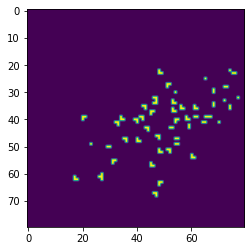

124.0


In [ ]:
# read in red labels 
rfr = ROIFileReader(red_rois_filename)
red_rois = rfr.get_roi_list()

print(red_rois, len(red_rois))
red_rois = [LaminarROI(rr).get_points() for rr in red_rois]
print(red_rois, len(red_rois))
red_roi_map = np.zeros((n, m))
for roi in red_rois:
    for px in roi:
        i, j = px
        red_roi_map[j][i] = 1
plt.imshow(red_roi_map)
plt.show()
print(np.sum(red_roi_map))